# Introduction

In this notebook we will:
- [create a global weather database in Athena](#create)
- [query the weather database for relevant time-series](#query)
- [add the weather time-series to a forecast model](#model)

<a id='create'></a>

## Creating Weather Database

### Download the data

One of the best sources for historical weatehr data is the NOAA archive: https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/

In [2]:
import pandas as pd

Let's see what files are available for download from their website

In [3]:
website_directory = pd.read_html('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/')[0]

In [4]:
website_directory

,Name,Last modified,Size,Description
0,NaN,NaN,NaN,NaN
1,Parent Directory,NaN,-,NaN
2,COOPDaily_announcement_042011.doc,2011-04-20 14:54,34K,NaN
3,COOPDaily_announcement_042011.pdf,2011-04-20 14:54,122K,NaN
4,COOPDaily_announcement_042011.rtf,2011-04-20 14:54,66K,NaN
5,all/,2021-02-03 10:36,-,NaN
6,by_station/,2021-03-26 11:03,-,NaN
7,by_year/,2021-03-25 15:34,-,NaN
8,figures/,2020-04-29 12:28,-,NaN
9,ghcnd-countries.txt,2018-11-16 16:50,3.6K,NaN


Since we need a specific set of years for our models, we will focus on the _by_year_ folder

In [5]:
yearly_directory = pd.read_html('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/')[0]

In [6]:
yearly_directory

,Name,Last modified,Size,Description
0,NaN,NaN,NaN,NaN
1,Parent Directory,NaN,-,NaN
2,1763.csv.gz,2021-04-14 11:26,3.3K,NaN
3,1764.csv.gz,2021-04-14 11:27,3.2K,NaN
4,1765.csv.gz,2021-04-14 11:25,3.3K,NaN
...,...,...,...,...
258,2019.csv.gz,2021-04-14 11:26,144M,NaN
259,2020.csv.gz,2021-04-14 11:26,141M,NaN
260,2021.csv.gz,2021-04-14 11:27,36M,NaN
261,readme-by_year.txt,2021-03-08 10:06,1.1K,NaN


We have data from 1763 until this year (2021)

### Copy the relevant data to S3

Our database will use Amazon Athena that needs the data close in S3. Since we need only a few years of data, the overall data will be less than 1GB

I'll skip the part of creating the bucket for the database, and I'll assume that you already did it. I'll use a simple trick to move data directly from a web URL into S3 using `wget`

In [167]:
data_bucket = 'weather-data-ml'

In [7]:
!wget -qO- https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2021.csv.gz | aws s3 cp - s3://{data_bucket}/facts/year=2021/2021.csv.gz

We can loop over the years that we want to cover in our models:

In [8]:
for year in range(2015,2020):
    !wget -qO- https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz | aws s3 cp - s3://{data_bucket}/facts/year={year}/{year}.csv.gz

To make it more cost effective, we will use partition format by year. A simple way to achieve it is to create folders in the partition format, and name the folder by the parition_key=partition_value structure. For example `year=2021`.

Here is the list of the folders in S3 after we copied the data there.

In [168]:
!aws s3 ls s3://{data_bucket}/facts/

                           PRE year=2015/
                           PRE year=2016/
                           PRE year=2017/
                           PRE year=2018/
                           PRE year=2019/
                           PRE year=2020/
                           PRE year=2021/


### Create the Athena Tables

Athena is based on PrestoDB and allows query data using SQL over raw files in S3. Once we have the raw data in S3, we can create the table as `EXTERNAL TABLE`. One option to do it is to use AWS Glue crawlers, however, it is also relatively simple to define the table directly in Athena with `CREATE EXTERNAL TABLE` statements. 

First, we will install the needed python library to access Athena [_PyAthena_](https://pypi.org/project/pyathena/) and _SQLAlchemy_.

In [11]:
pip install PyAthena

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install PyAthena[Pandas]

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install PyAthena[SQLAlchemy]

Note: you may need to restart the kernel to use updated packages.


Based on the [readme](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) file on the service website we know the structure of the data.

* We will start with a new DB (weather) and a new table (facts)
* The columns as they are described in the README file
* The partition as we defined in the folder structure
* We are using the default text format of the CSV (delimited by ,)
* We define the location of the files in S3
* We add the compression type of the files (gzip, based on the .gz of the file names)

In [169]:
create_facts_table = f'''
CREATE EXTERNAL TABLE weather.facts(
  station_id string, 
  `_date` string, 
  element string, 
  element_value bigint, 
  measurement_flag string, 
  quality_flag string, 
  source_flag string, 
  observation_time bigint)
PARTITIONED BY ( 
  year bigint)
ROW FORMAT DELIMITED 
  FIELDS TERMINATED BY ',' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://{data_bucket}/facts'
TBLPROPERTIES (
  'classification'='csv', 
  'compressionType'='gzip', 
  'delimiter'=',', 
  'typeOfData'='file')
'''

Athena is writing all the output of the queries into a dedicated bucket in S3. Please note that the bucket should be in the same region of the Athena and S3, otherwise you might pay on data transfer or be blocked by AWS from doing it.

In [170]:
athena_bucket = 's3://aws-athena-query-results-672915487120-eu-west-1'

In [421]:
from pyathena import connect

conn = connect(
    s3_staging_dir=athena_bucket,
    region_name='eu-west-1',
    work_group='primary2'
)

Once we have the connection defined we can execute the `CREATE EXTERNAL TABLE` statement:

In [48]:
cursor=conn.cursor()
cursor.execute(create_facts_table);

We have a table with partitions based on the folder structure. Before we can query it, after we created it, we need to load all the partitions. The following command is doing it:

In [403]:
cursor.execute('MSCK REPAIR TABLE weather.facts;');

Now we can try to query the table. We will use the integration of PyAthena with Pandas to load the query result directly into a DataFrame.

In [308]:
df = pd.read_sql("SELECT * FROM weather.facts limit 10", conn)
df.head()

,station_id,_date,element,element_value,measurement_flag,quality_flag,source_flag,observation_time,year
0,AE000041196,20150101,TMIN,125,,,S,None,2015
1,AE000041196,20150101,PRCP,0,,,S,None,2015
2,AE000041196,20150101,TAVG,206,H,,S,None,2015
3,AEM00041194,20150101,TMAX,286,,,S,None,2015
4,AEM00041194,20150101,TMIN,180,,,S,None,2015


,station_id,_date,element,element_value,measurement_flag,quality_flag,source_flag,observation_time,year
0,AE000041196,20150101,TMIN,125,,,S,None,2015
1,AE000041196,20150101,PRCP,0,,,S,None,2015
2,AE000041196,20150101,TAVG,206,H,,S,None,2015
3,AEM00041194,20150101,TMAX,286,,,S,None,2015
4,AEM00041194,20150101,TMIN,180,,,S,None,2015


### Query the facts table

We can have different queries against the new table based on the many various _elements_ that it covers. For example, in the documentation we can see the special weather types are available under `WT##`.

Let's check the list of Tornados (`WT10`) in 2020:

In [50]:
df_tornado = pd.read_sql("SELECT * FROM weather.facts where year = 2020 and element = 'WT10';", conn)
df_tornado

,station_id,_date,element,element_value,measurement_flag,quality_flag,source_flag,observation_time,year
0,USW00022534,20200418,WT10,1,,,W,None,2020
1,USW00012844,20200607,WT10,1,,,W,None,2020
2,USW00012836,20200612,WT10,1,,,W,None,2020
3,USW00012885,20200612,WT10,1,,,W,None,2020
4,USW00092805,20200612,WT10,1,,,W,None,2020
5,USW00012916,20200625,WT10,1,,,W,None,2020
6,USW00003855,20200630,WT10,1,,,W,None,2020
7,USW00012885,20200715,WT10,1,,,W,None,2020
8,USW00012836,20200809,WT10,1,,,W,None,2020
9,USW00093719,20200813,WT10,1,,,W,None,2020


### Create Stations Table

We have also a metadata file that is describing the location of each of the weather stations. We will need to know this information to be able to have a specific location infromation.

We will download the file from the service website directly into S3 and put it under a new folder called _meta_

In [173]:
!wget -qO- https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt | aws s3 cp - s3://{data_bucket}/meta/ghcnd-stations.txt

Based on the above README file, we also know the structure of the stations file and define its table. This file is different as it is not a simple SCV file and the values are in a specific character position. A simple way to parse it is to use Grok format in Glue crawler, or use a simple regular expression (regex) that is based on the fact that the fields are separated by a blank character and `[^ ]*` can capture everything between these blanks. We also need to define the SERDE library to support regex (_org.apache.hadoop.hive.serde2.RegexSerDe_)

In [65]:
create_stations_table = f'''
CREATE EXTERNAL TABLE weather.stations (
  station_id string, 
  latitude double, 
  longitude double, 
  elevation double, 
  name string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.RegexSerDe' 
WITH SERDEPROPERTIES ( 
  'input.regex'='([^ ]*)\\\s*([^ ]*)\\\s*([^ ]*)\\\s*([^ ]*)\\\s*(.+)$') 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://{data_bucket}/meta/'
TBLPROPERTIES (
  'typeOfData'='file')

'''

In [66]:
cursor.execute(create_stations_table);

<a id='query'></a>

# Query the weather database for relevant time-series

Now, we can identify what are the closest weather station to each location and use their ids to get the weather measurement for the relevant time period.

We Select the location and the element that we want its values (_PRCP_, for example):

In [439]:
lat = 32.277115560505784
lng = 34.83934224061254
element = 'PRCP'

* Select the date for each measure
* and the average of values as a way to triangulate the actual location
* from the closest weather stations 
* as it is calculated by the geospacial distance of their coordinates
* for the specific year and time range
* for each day in the database
* in an ascending order by date

In [440]:
time_series_query = f'''
SELECT 
    date_parse(_date, '%Y%m%d') as ds, 
    avg(element_value) as value
FROM weather.facts 
WHERE element = '{element}' AND station_id in (
  SELECT station_id from (
    SELECT *, ST_Distance(
      ST_Point({lng},{lat}), 
      ST_Point(longitude, latitude)) as distance 
    FROM weather.stations
    ORDER by distance ASC limit 3
  )
) AND year = 2021
GROUP BY _date
ORDER by _date
'''

In [441]:
df_prcp = pd.read_sql(time_series_query, conn)
df_prcp

,ds,value
0,2021-01-08,0.0
1,2021-01-14,48.0
2,2021-01-15,122.0
3,2021-01-16,13.0
4,2021-01-17,0.0
5,2021-01-18,353.0
6,2021-01-19,41.0
7,2021-01-20,0.0
8,2021-01-21,0.0
9,2021-01-24,0.0


Or we can `JOIN` the two table to get the location of information of the Tornados that we saw before

In [176]:
tornado_query = f'''
SELECT * FROM weather.facts f
JOIN weather.stations s ON f.station_id = s.station_id
WHERE year = 2020 AND element = 'WT10';
'''

In [75]:
df_tornado = pd.read_sql(tornado_query, conn)
df_tornado

,station_id,_date,element,element_value,measurement_flag,quality_flag,source_flag,observation_time,year,station_id,latitude,longitude,elevation,name
0,USW00012844,20200607,WT10,1,,,W,None,2020,USW00012844,26.6847,-80.0994,5.8,FL WEST PALM BEACH INTL AP 72203
1,USW00012885,20200612,WT10,1,,,W,None,2020,USW00012885,26.1969,-80.1708,4.3,FL FT LAUDERDALE EXECUTIVE AP
2,USW00012885,20200715,WT10,1,,,W,None,2020,USW00012885,26.1969,-80.1708,4.3,FL FT LAUDERDALE EXECUTIVE AP
3,USW00053917,20200820,WT10,1,,,W,None,2020,USW00053917,30.0494,-90.0289,2.7,LA NEW ORLEANS LAKEFRONT AP
4,USW00023188,20201122,WT10,1,,,W,None,2020,USW00023188,32.7336,-117.1831,4.6,CA SAN DIEGO LINDBERGH FLD GSN 72290
5,USW00012836,20200612,WT10,1,,,W,None,2020,USW00012836,24.5550,-81.7522,1.2,FL KEY WEST INTL AP GSN HCN 72201
6,USW00092805,20200612,WT10,1,,,W,None,2020,USW00092805,26.2500,-80.1083,6.4,FL POMPANO BEACH AIRPARK
7,USW00012836,20200809,WT10,1,,,W,None,2020,USW00012836,24.5550,-81.7522,1.2,FL KEY WEST INTL AP GSN HCN 72201
8,USW00093719,20200813,WT10,1,,,W,None,2020,USW00093719,35.0678,-77.0481,5.8,NC NEW BERN CRAVEN CO AP
9,USW00012836,20200903,WT10,1,,,W,None,2020,USW00012836,24.5550,-81.7522,1.2,FL KEY WEST INTL AP GSN HCN 72201


<a id='model'></a>

## Add weather data to a forecast model

To test the contribution of the weather data to a forecasting model, we will choose one of the classical forecasting competition in Kaggle. The competition is trying to predict how many restaurant reservation will be cancelled to different restaurants in Japan. It is easy to assume that if it is raining, more people will decide to stay home and cancel their restaurant reservation. 

I assume that you have a free account in Kaggle and you can download dataset from their site. Here, we will use the Kaggle API to download the relevant dataset. 

In [76]:
pip install kaggle

     |████████████████████████████████| 58 kB 7.4 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 6.4 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 9.8 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=bdf872dd64f5ac05677d62a1e82b5a1d970de430869e3544d252b35a75f54ce8
  Stored in directory: /home/ec2-user/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=4f218349b80ad20846913bb366db665ca7d72516d18e309c387fe148f15dfa1a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/72/e6/db/122611605e60148f54ee2abaca98b2bbeafc6e22486a867bad
Successfully built kaggle python-slugify
Note: you may need to restart the kernel to use updated packages.


In [85]:
!kaggle competitions download -c recruit-restaurant-visitor-forecasting

 69%|██████████████████████████▎           | 18.0M/26.0M [00:01<00:00, 11.9MB/s]
100%|██████████████████████████████████████| 26.0M/26.0M [00:01<00:00, 16.9MB/s]


After you unzip the files, you will see the following structure:

In [87]:
%ls -l restaurants/

total 139164
-rw-r--r-- 1 ec2-user ec2-user   5827666 Nov 21  2017 air_reserve.csv
-rw-r--r-- 1 ec2-user ec2-user     74450 Nov 21  2017 air_store_info.csv
-rw-r--r-- 1 ec2-user ec2-user   8755742 Nov 21  2017 air_visit_data.csv
-rw-r--r-- 1 ec2-user ec2-user     10968 Nov 21  2017 date_info.csv
-rw-r--r-- 1 ec2-user ec2-user 126244535 Nov 21  2017 hpg_reserve.csv
-rw-r--r-- 1 ec2-user ec2-user    478650 Nov 21  2017 hpg_store_info.csv
-rw-r--r-- 1 ec2-user ec2-user   1088658 Nov 21  2017 sample_submission.csv
-rw-r--r-- 1 ec2-user ec2-user      6326 Nov 21  2017 store_id_relation.csv


The competition is using two dataset from two different services. However, for this quick excercise we will only use one of the datasets. Let's load the reservation data:

In [179]:
air_reserve_df = pd.read_csv('restaurants/air_reserve.csv')

In [180]:
air_reserve_df

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10


* Group the record by restaurant (_air_store_id_)
* sum the number of visitors each resturant has in the dataset
* and pick the top 10

In [252]:
(
    air_reserve_df
    .groupby('air_store_id')
    ['reserve_visitors']
    .sum()
    .nlargest(10)
)

air_store_id
air_e55abd740f93ecc4    8355
air_03963426c9312048    8200
air_8093d0b565e9dbdf    7458
air_326ca454ef3558bc    7385
air_3bb99a1fe0583897    7321
air_24b9b2a020826ede    7122
air_cf5ab75a0afb8af9    6750
air_de692863bb2dd758    5746
air_f911308e19d64236    5726
air_0a74a5408a0b8642    5631
Name: reserve_visitors, dtype: int64

### Create time-series for the forecasting model

* Start with the full reservation table
* filter it to include only the top restaurant that we saw above
* convert the date column to datetime format
* resample the daily data to have all days in the range
* rename the columns to the values that are expected by the algorithm (_ds_, and _y_)

In [253]:
store_id = 'air_03963426c9312048'

In [254]:
daily_top_rest = (
    air_reserve_df
    .query('air_store_id == @store_id')
    .assign(ds = lambda r : pd.to_datetime(r.visit_datetime))
    .query('ds < "2016-07-15"')
    .set_index('ds')
    .resample('D')
    .sum()
    .reset_index()
    .rename(columns={
        'reserve_visitors':'y'
    })   
)
daily_top_rest

,ds,y
0,2016-01-07,17
1,2016-01-08,62
2,2016-01-09,54
3,2016-01-10,15
4,2016-01-11,24
...,...,...
133,2016-05-19,10
134,2016-05-20,0
135,2016-05-21,46
136,2016-05-22,12


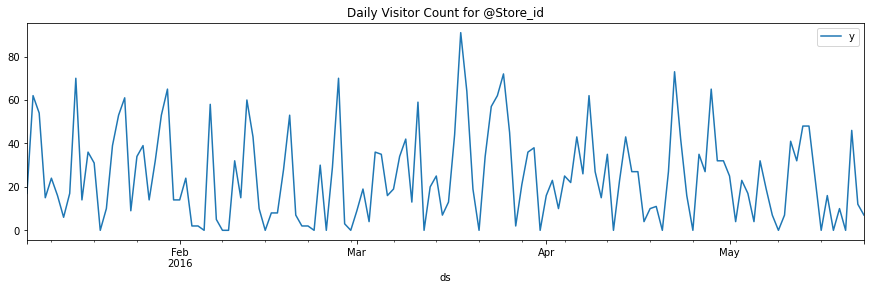

In [460]:
(
    daily_top_rest
    .plot
    .line(
        x='ds',
        figsize=(15,4),
        title='Daily Visitor Count for @Store_id'
    )
);

### Forecast Model

There are a few popular forecasting algorithms that can be used for this model. We will use the relatively new forecasting model from Facebook [Neural Prophet](https://neuralprophet.com/). After we installed it on our instance we can import it.

In [256]:
from neuralprophet import NeuralProphet

In [257]:
m = NeuralProphet()
df_train, df_val = m.split_df(daily_top_rest, freq='D', valid_p=0.2)

train_metrics = m.fit(df_train, freq='D')
val_metrics = m.test(df_val)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 362


  0%|          | 0/204 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.63E-01, min: 1.41E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 2.57E-01
Epoch[362/362]: 100%|██████████| 362/362 [00:06<00:00, 55.37it/s, SmoothL1Loss=0.0277, MAE=12.3, MSE=234, RegLoss=0]  
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE     MSE
1         0.036 13.358 302.231


Let's see the base line of the model with no

In [258]:
val_metrics

,SmoothL1Loss,MAE,MSE
0,0.035767,13.358081,302.231445


## Adding weather (rain) data

First, we need to find the location of restaurant. We will load the store information dataset and query it to find the relevant location.

In [259]:
air_store_info_df = pd.read_csv('restaurants/air_store_info.csv')

In [260]:
air_store_info_df

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


### Visualization of the locations

Let's check the different locations that we have in our data. I'll use my favorite visualization library Altair, with its easy to understand and describe code, yet powerful capabilities.

In [328]:
(
    air_store_info_df
    .air_genre_name
    .unique()
)

array(['Italian/French', 'Dining bar', 'Yakiniku/Korean food',
       'Cafe/Sweets', 'Izakaya', 'Okonomiyaki/Monja/Teppanyaki',
       'Bar/Cocktail', 'Japanese food', 'Creative cuisine', 'Other',
       'Western food', 'International cuisine', 'Asian', 'Karaoke/Party'],
      dtype=object)

In [311]:
pip install altair

     |████████████████████████████████| 727 kB 15.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [336]:
pip install vega_datasets

     |████████████████████████████████| 210 kB 15.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


* Create **background map** with countries shapes
* Create a **restaurant map** with the store info table above
* create a circle for each location 
* using its longitude as x, and latitude as y
* use as color the type of the store using _air_genre_name_ column
* add a tooltip with the type and area name
* Create a map with both charts 
* Zoom in and move it to center on Japan

In [466]:
import altair as alt
from vega_datasets import data

background = alt.Chart(
    alt
    .topo_feature(
        data.world_110m.url, 
        'countries'
    )
).mark_geoshape(
    fill='#ddd', stroke='#fff', strokeWidth=1
)

restaurants = alt.Chart(
        air_store_info_df
).mark_circle(
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color=alt.Color(
        "air_genre_name:N", 
        scale=alt.Scale(
            domain=list(
                air_store_info_df
                .air_genre_name
                .unique()
            )
        ),
        title='Restaurant Type'
    ),
    size=alt.value(50),
    tooltip=[
        alt.Tooltip(
            'air_area_name:N', 
            title='Area Name'
        ),
        alt.Tooltip(
            'air_genre_name:N',
            title='Restaurant Type'
        )
    ]
)

alt.layer(
    background,
    restaurants
).project(
    type='mercator',
    scale=750, 
    translate=[-1650, 700]
).properties(
    title='Restaurants Locations in AirREGI dataset',
    width=300,
    height=300
)

alt.LayerChart(...)

### Find weather data for a specific location

We will start with one of the top restaurant

In [451]:
air_store_location = (
    air_store_info_df
    .query('air_store_id == @store_id')
    [['longitude','latitude']]
)

In [452]:
lng = air_store_location.iloc[0,0]
lat = air_store_location.iloc[0,1]
(lng,lat)

(132.4550176, 34.386244500000004)

In [457]:
closest_stations_query = f'''
SELECT *, ST_Distance(
  to_spherical_geography(ST_Point({lng},{lat})), 
  to_spherical_geography(ST_Point(longitude, latitude)) 
    ) as distance 
FROM weather.stations
ORDER by distance ASC limit 5
'''

In [458]:
df_closest_stations = pd.read_sql(closest_stations_query, conn)
df_closest_stations

,station_id,latitude,longitude,elevation,name,distance
0,JA000047765,34.400,132.4670,53.0,HIROSHIMA 47765,1883.697039
1,JA000047766,34.233,132.5670,4.0,KURE REG MET HQ 47766,19903.525456
2,JAW00043322,34.150,132.2333,3.0,IWAKUNI,33244.281184
3,JAW00043324,34.150,132.2333,3.0,IWAKUNI 47764,33244.281184
4,JA000047887,33.850,132.7830,34.0,MATSUYAMA 47887,66836.111911


In [459]:
stations = alt.Chart(
    df_closest_stations
).mark_circle(
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.value(50),
    tooltip=[
        'name:N',
        'station_id:N',
        alt.Tooltip('distance:Q', format=',.0f', title='Distance in meters')
    ]
)
restaurant = alt.Chart(
    air_store_location
).mark_point(
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.value(50)
).properties(
    title='Closest Weather Stations'
)
stations + restaurant

alt.LayerChart(...)

In [468]:
time_series_query = f'''
SELECT 
    date_parse(_date, '%Y%m%d') as ds, 
    avg(element_value) as value
FROM weather.facts 
WHERE element = '{element}' AND station_id in (
  SELECT station_id from (
    SELECT *, ST_Distance(
      ST_Point({lng}, {lat}), 
      ST_Point(longitude, latitude)) as distance 
    FROM weather.stations
    ORDER by distance ASC limit 3
  )
) AND year between 2016 and 2017
GROUP BY _date
ORDER by _date

'''

In [469]:
df_prcp = pd.read_sql(time_series_query, conn)
df_prcp

,ds,value
0,2016-01-01,5.0
1,2016-01-02,0.0
2,2016-01-03,0.0
3,2016-01-04,0.0
4,2016-01-05,0.0
...,...,...
724,2017-12-27,0.0
725,2017-12-28,0.0
726,2017-12-29,0.0
727,2017-12-30,0.0


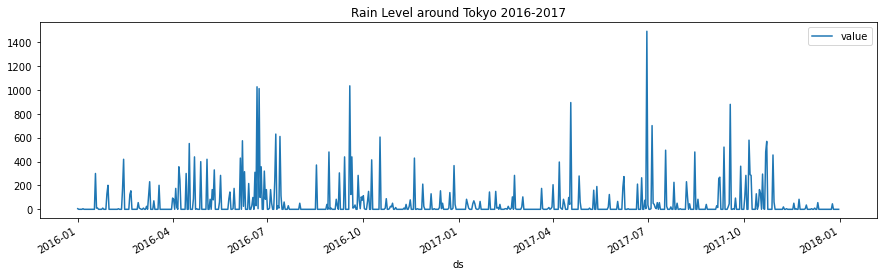

In [470]:
(
    df_prcp
    .plot
    .line(
        x='ds',
        figsize=(15,4),
        title='Rain Level around Tokyo 2016-2017'
    )
);

In [267]:
daily_top_rest_with_weather = (
    daily_top_rest
    .assign(ds = lambda r : pd.to_datetime(r.ds))
    .merge(
        df_prcp,
        on='ds',
        how='left'
    )
    .fillna(0)
)
daily_top_rest_with_weather

,ds,y,value
0,2016-01-07,17,0.0
1,2016-01-08,62,0.0
2,2016-01-09,54,0.0
3,2016-01-10,15,0.0
4,2016-01-11,24,0.0
...,...,...,...
133,2016-05-19,10,0.0
134,2016-05-20,0,0.0
135,2016-05-21,46,0.0
136,2016-05-22,12,0.0


### Plot reservation data with the weather data

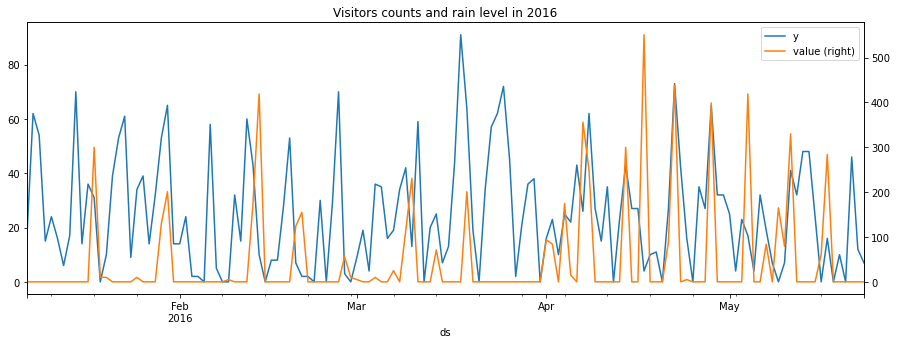

In [471]:
(
    daily_top_rest_with_weather
    .plot
    .line(
        x='ds',
        secondary_y=['value'],
        figsize=(15,5),
        title='Visitors counts and rain level in 2016'
        
    )
);

In [269]:
m = NeuralProphet()
df_train, df_val = m.split_df(daily_top_rest_with_weather, freq='D', valid_p=0.2)
m = m.add_future_regressor(name='value', regularization=0.01)

train_metrics = m.fit(df_train, freq='D')
val_metrics = m.test(df_val)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 362


  0%|          | 0/204 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.17E-01, min: 1.13E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 5.32E-01
Epoch[362/362]: 100%|██████████| 362/362 [00:07<00:00, 46.79it/s, SmoothL1Loss=0.0275, MAE=12.3, MSE=232, RegLoss=0.000248]
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE     MSE
1         0.037 13.839 312.108


In [270]:
val_metrics

,SmoothL1Loss,MAE,MSE
0,0.036936,13.838798,312.108429


## NYC Taxi Ride Dataset

Let's try a different dataset and see if we can improve on the default forecast with the weather data. We will use another dataset that is available in Kaggle: _NYC-TAXI-TRIP-DURATION_

In [272]:
!kaggle competitions download -c nyc-taxi-trip-duration

 99%|█████████████████████████████████████▋| 85.0M/85.8M [00:01<00:00, 59.2MB/s]
100%|██████████████████████████████████████| 85.8M/85.8M [00:01<00:00, 49.7MB/s]


In [273]:
taxi_train = pd.read_csv('taxi/train.csv')

In [274]:
taxi_train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [283]:
ride_count = (
    taxi_train
    .assign(ds = lambda r : pd.to_datetime(r.pickup_datetime))
    .set_index('ds')
    ['id']
    .resample('1H')
    .count()
    .reset_index()
    .rename(columns={
        'id':'y'
    })
)
ride_count

,ds,y
0,2016-01-01 00:00:00,546
1,2016-01-01 01:00:00,566
2,2016-01-01 02:00:00,503
3,2016-01-01 03:00:00,479
4,2016-01-01 04:00:00,323
...,...,...
4363,2016-06-30 19:00:00,484
4364,2016-06-30 20:00:00,440
4365,2016-06-30 21:00:00,484
4366,2016-06-30 22:00:00,462


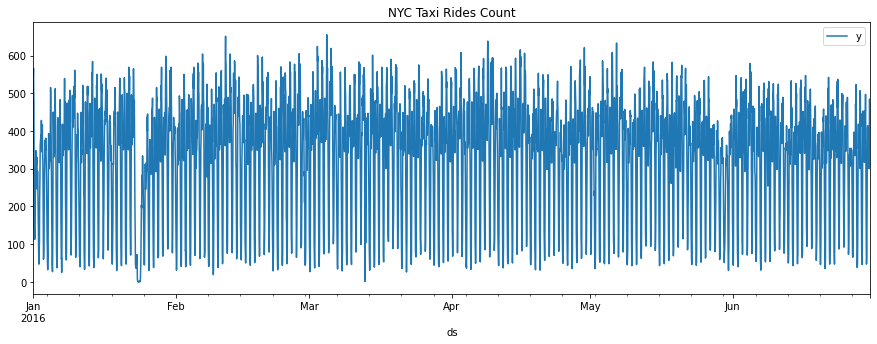

In [472]:
(
    ride_count
    .plot
    .line(
        x='ds',
        figsize=(15,5),
        title='NYC Taxi Rides Count'
    )
);

In [285]:
m = NeuralProphet()
df_train, df_val = m.split_df(ride_count, freq='1H', valid_p=0.2)

train_metrics = m.fit(df_train, freq='iH')
val_metrics = m.test(df_val)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 87


  0%|          | 0/277 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.81E-02, min: 3.80E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 1.60E-01
Epoch[87/87]: 100%|██████████| 87/87 [00:27<00:00,  3.18it/s, SmoothL1Loss=0.0109, MAE=59.6, MSE=6.52e+3, RegLoss=0]
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE      MSE
1         0.010 60.235 5802.944


In [286]:
val_metrics

,SmoothL1Loss,MAE,MSE
0,0.009733,60.235149,5802.943848


### Adding Weather Data

We will use a location within NYC to get the weather stations around it

In [287]:
lng = -73.982201
lat = 40.745522

In [445]:
time_series_query = f'''
SELECT 
    date_parse(_date, '%Y%m%d') as ds, 
    avg(element_value) as value
FROM weather.facts 
WHERE element = '{element}' AND station_id in (
  SELECT station_id from (
    SELECT *, ST_Distance(
      ST_Point({lng}, {lat}), 
      ST_Point(longitude, latitude)) as distance 
    FROM weather.stations
    ORDER by distance ASC limit 3
  )
) AND year = 2016 
GROUP BY _date
ORDER by _date

'''

In [291]:
df_prcp = pd.read_sql(time_series_query, conn)
df_prcp

,ds,value
0,2016-01-01,0.0
1,2016-01-02,0.0
2,2016-01-03,0.0
3,2016-01-04,0.0
4,2016-01-05,0.0
...,...,...
361,2016-12-27,0.0
362,2016-12-28,0.0
363,2016-12-29,99.0
364,2016-12-30,3.0


Since we have daily data we will simply put use the daily value for all the hours of that day

In [300]:
hourly_prcp = (
    df_prcp
    .set_index('ds')
    .resample('1H')
    .ffill()
)

In [301]:
ride_count_with_weather = (
    ride_count
    .merge(
        hourly_prcp,
        on='ds',
        how='left'
    )
    .fillna(0)
)

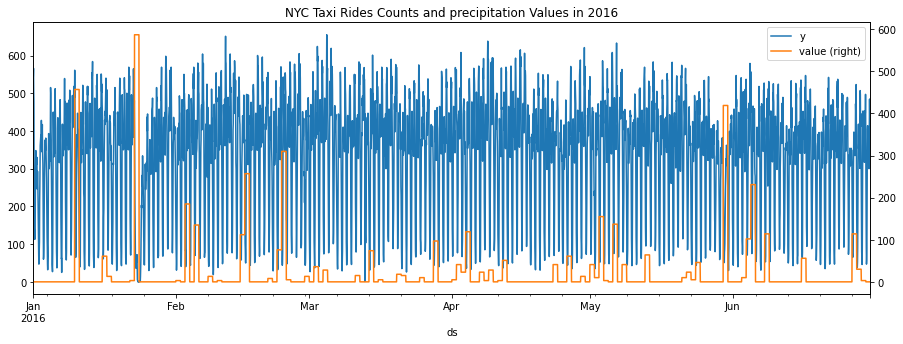

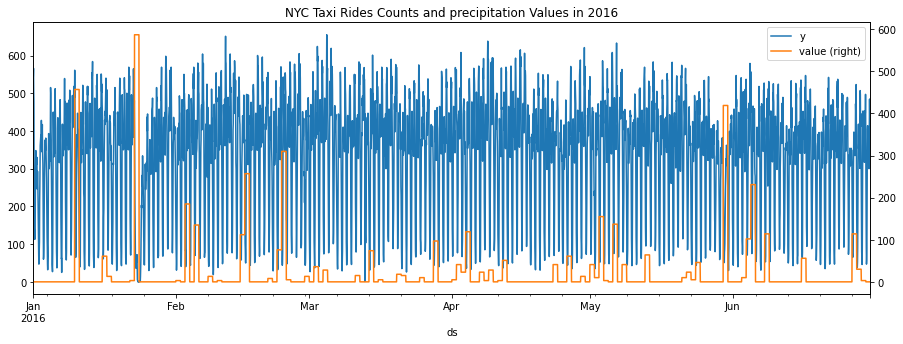

In [306]:
(
    ride_count_with_weather
    .plot
    .line(
        x='ds',
        secondary_y=['value'],
        figsize=(15,5),
        title='NYC Taxi Rides Counts and precipitation Values in 2016'
    )
);

### Training the model with weather factor

Neural Prophet has the option to add a regressor as a [future regressor](https://neuralprophet.com/model/future-regressors/).

In [303]:
m = NeuralProphet()
df_train, df_val = m.split_df(ride_count_with_weather, freq='1H', valid_p=0.2)
m = m.add_future_regressor(name='value', regularization=0.05)

train_metrics = m.fit(df_train, freq='1H')
val_metrics = m.test(df_val)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 87


  0%|          | 0/277 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.31E-01, min: 7.41E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 4.15E-01
Epoch[87/87]: 100%|██████████| 87/87 [00:33<00:00,  2.61it/s, SmoothL1Loss=0.011, MAE=59.3, MSE=6.53e+3, RegLoss=9.62e-6]  
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE      MSE
1         0.010 59.142 5681.150


In [304]:
val_metrics

,SmoothL1Loss,MAE,MSE
0,0.009528,59.142017,5681.149902


## Conclusion 

The validation metrics were slightly better when the weather regressor was added to the model. As expected, sometime the addition of the weather data is helping the models and sometimes the model can't use the data as is. 